## TF2 setup

In [3]:
!pip install tf-nightly-gpu-2.0-preview

     |████████████████████████████████| 349.2MB 42kB/s 
     |████████████████████████████████| 430kB 51.5MB/s 
     |████████████████████████████████| 61kB 31.0MB/s 
     |████████████████████████████████| 3.1MB 39.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/89/67/41/63cbf0f6ac0a6156588b9587be4db5565f8c6d8ccef98202fc
Successfully built wrapt
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
  Found existing installation: wrapt 1.10.11
    Uninstalling wrapt-1.10.11:
      Successfully uninstalled wrapt-1.10.11


In [4]:
import tensorflow as tf

print(tf.version.VERSION)
print(tf.test.is_gpu_available())

%load_ext tensorboard

2.0.0-dev20190526
True


In [0]:
import datetime, os

import numpy as np
from matplotlib import pyplot as plt

In [0]:
TARGET_SIZE = [192, 192]
# TODO: clean-up IMAGE_SIZE
IMAGE_SIZE = TARGET_SIZE

DATASET_FOLDER = './dataset/tfrec/'


# steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
steps_per_epoch = 32
EPOCHS = 1

CLASSES = [b'converse chuck 70', b'Exaggerated Soles', b'nike air max 90 essentials', b'nike react', b'Tie Dye sneakers']

In [0]:
# TODO: clean-up this one
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  if tf.executing_eagerly():
    # In eager mode, iterate in the Datset directly.
    for images, labels, _, _, _, _ in dataset:
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()
      break;
      
  else: # In non-eager mode, must get the TF note that 
        # yields the nextitem and run it in a tf.Session.
    get_next_item = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as ses:
      numpy_images, numpy_labels = ses.run(get_next_item)

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(label.numpy().decode("utf-8"), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## Read data

In [0]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        
        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "label":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "size":          tf.io.FixedLenFeature([2], tf.int64),  # two integers
        "one_hot_class": tf.io.VarLenFeature(tf.float32)        # a certain number of floats
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    
    class_num = example['class']
    
    label  = example['label']
    height = example['size'][0]
    width  = example['size'][1]
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    return image, class_num, label, height, width, one_hot_class
    
# read from TFRecords. For optimal performance, use "interleave(tf.data.TFRecordDataset, ...)"
# to read from multiple TFRecord files at once and set the option experimental_deterministic = False
# to allow order-altering optimizations.

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

raw_data = tf.data.Dataset.list_files(DATASET_FOLDER + "*.tfrec")
raw_data = raw_data.with_options(option_no_order)
#raw_data = tf.data.TFRecordDataset(filenames, num_parallel_reads=16)
raw_data = raw_data.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=tf.data.experimental.AUTOTUNE)
raw_data = raw_data.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
raw_data = raw_data.shuffle(300)

display_dataset = raw_data.map(lambda image, class_num, label, height, width, one_hot_class: (image, label))

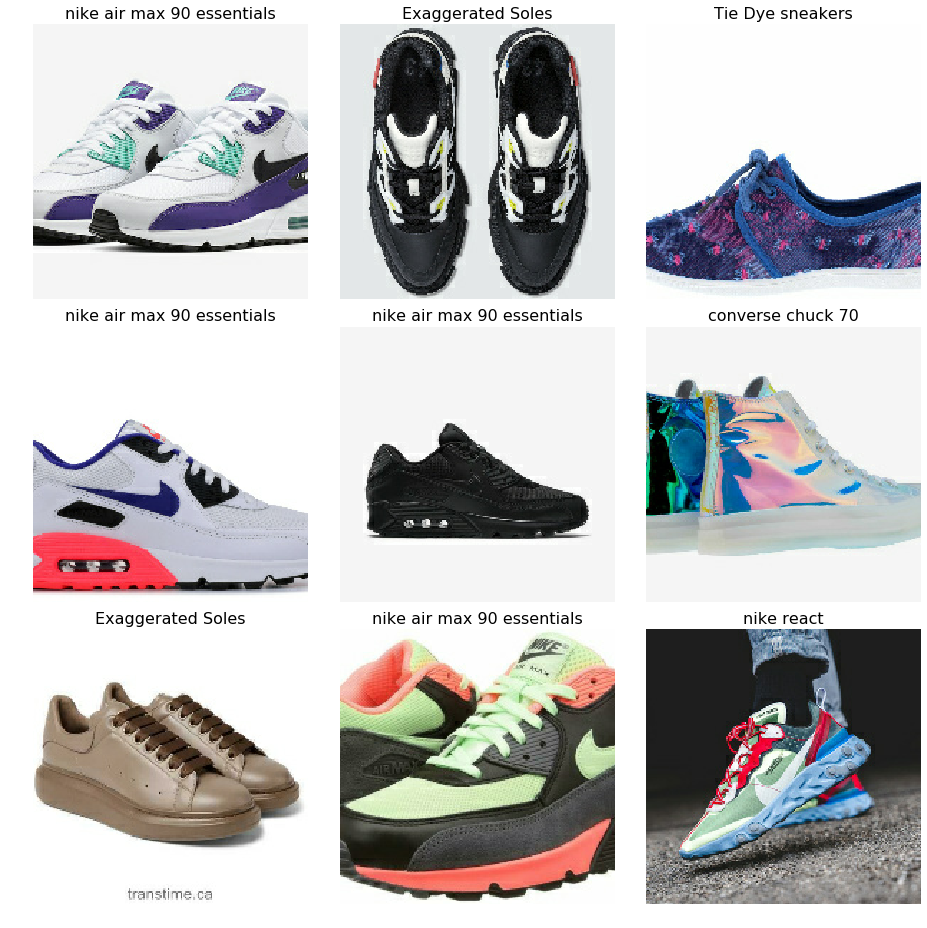

In [84]:
display_9_images_from_dataset(display_dataset)

## Model

### training and validation datasets

In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000


train_dataset = raw_data.map(lambda image, class_num, label, height, width, one_hot_class: (image, one_hot_class))

train_batches = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [88]:
for image_batch, label_batch in train_batches.take(1):
  print(image_batch.shape, label_batch.shape)
  
print(label_batch[0].numpy())

(32, 192, 192, 3) (32, 5)
[0. 1. 0. 0. 0.]


### Simplest model

In [0]:
for data, label in train_batches.take(1):
  print(data.shape)
  print(data[0])

(32, 192, 192, 3)
tf.Tensor(
[[[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [253 253 253]
  [253 253 253]
  [253 253 253]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 ...

 [[ 24  37   0]
  [ 22  35   0]
  [ 22  35   0]
  ...
  [ 26  36   1]
  [ 23  33   0]
  [ 25  32   0]]

 [[ 32  45   0]
  [ 27  40   0]
  [ 26  39   0]
  ...
  [ 34  46   0]
  [ 32  44   0]
  [ 32  44   0]]

 [[ 46  59   6]
  [ 41  53   3]
  [ 39  51   1]
  ...
  [ 46  61   2]
  [ 41  56   0]
  [ 39  54   0]]], shape=(192, 192, 3), dtype=uint8)


### normalize

The image data is raw, values from 1 to 255. There are different ways to normalize such data.

One way to solve this with `tf.keras.preprocessing.image.ImageDataGenerator`

```
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)
```


In [0]:
def normalize_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  return image, label

In [0]:
train_normalized_dataset = raw_data.map(lambda image, class_num, label, height, width, one_hot_class: (image, one_hot_class)).map(normalize_example)
train_normalized_batches = train_normalized_dataset.shuffle(SHUFFLE_BUFFER_SIZE).repeat().batch(BATCH_SIZE)



In [90]:
for data, label in train_normalized_batches.take(1):
  print(data.shape)
  print(data[0])

(32, 192, 192, 3)
tf.Tensor(
[[[ 0.2313726   0.1686275  -0.01176471]
  [ 0.2313726   0.1686275  -0.01176471]
  [ 0.23921573  0.17647064 -0.00392157]
  ...
  [ 0.6627451   0.56078434  0.30980396]
  [ 0.8901961   0.7490196   0.45098042]
  [ 0.81960785  0.67058825  0.33333337]]

 [[ 0.24705887  0.18431377  0.0196079 ]
  [ 0.24705887  0.18431377  0.0196079 ]
  [ 0.24705887  0.18431377  0.0196079 ]
  ...
  [ 0.6862745   0.56078434  0.27843142]
  [ 0.8745098   0.70980394  0.35686278]
  [ 0.8509804   0.67058825  0.27843142]]

 [[ 0.254902    0.19215691  0.02745104]
  [ 0.254902    0.19215691  0.02745104]
  [ 0.24705887  0.18431377  0.0196079 ]
  ...
  [ 0.73333335  0.5764706   0.28627455]
  [ 0.85882354  0.67058825  0.32549024]
  [ 0.8745098   0.654902    0.27843142]]

 ...

 [[-0.46666664 -0.42745095 -0.4823529 ]
  [-0.5137255  -0.47450978 -0.5294118 ]
  [-0.5764706  -0.5372549  -0.5921569 ]
  ...
  [-0.54509807 -0.49019605 -0.42745095]
  [-0.54509807 -0.4823529  -0.4588235 ]
  [-0.56078434 

In [0]:
# TODO: replace to number of classes in last layer

def create_model_simplest():
  ### QUESTION 1.
  model = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=[*IMAGE_SIZE, 3]),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(256, activation='relu'),
      
      tf.keras.layers.Dense(5, activation='softmax')
  ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss = 'categorical_crossentropy',
      metrics=['accuracy']
  )

  model.summary()
  
  return model

In [92]:
model = create_model_simplest()

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


model.fit(train_normalized_batches, steps_per_epoch=steps_per_epoch, epochs=10,
#                     validation_data=validation_dataset, validation_steps=validation_steps)
          callbacks=[tensorboard_callback])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 110592)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               56623616  
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 1285      
Total params: 57,018,885
Trainable params: 57,018,885
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 8s 236ms/step - loss: 12.4571 - accuracy: 0.1973
Epoch 

### Batch Norm

In [0]:
# TODO: replace to number of classes in last layer

def create_model_simplest():
  ### QUESTION 1.
  model = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=[*IMAGE_SIZE, 3]),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(256, activation='relu'),
      
      tf.keras.layers.Dense(5, activation='softmax')
  ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss = 'categorical_crossentropy',
      metrics=['accuracy']
  )

  model.summary()
  
  return model

In [0]:
model = create_model_simplest()

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


model.fit(train_batches, steps_per_epoch=steps_per_epoch, epochs=10,
#                     validation_data=validation_dataset, validation_steps=validation_steps)
          callbacks=[tensorboard_callback])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 110592)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 110592)            442368    
_________________________________________________________________
dense_27 (Dense)             (None, 512)               56623616  
_________________________________________________________________
dense_28 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 1285      
Total params: 57,198,597
Trainable params: 56,977,413
Non-trainable params: 221,184
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 7s 231ms/step - loss: 12.3821 - accuracy: 0.2090
E

### Convolutional Neural Network


In [0]:
# TODO: replace to number of classes in last layer

def create_model_cnn():
  
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=[*IMAGE_SIZE, 3]))
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Dropout(0.4))
  
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Dropout(0.4))
  
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
  
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dense(5, activation='softmax'))
  

  model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss = 'categorical_crossentropy',
      metrics=['accuracy']
  )

  model.summary()
  
  return model


In [94]:
model = create_model_cnn()

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


model.fit(train_normalized_batches, steps_per_epoch=steps_per_epoch, epochs=10,
#                     validation_data=validation_dataset, validation_steps=validation_steps)
          callbacks=[tensorboard_callback])

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 190, 190, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 95, 95, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 93, 93, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 44, 44, 64)      

### Transfer learning

Based on Keras models


We can also decide depending on amount of data if we use base network for just feature extraction.

In [0]:
# TODO: replace to number of classes in last layer

def create_model_app(base_model):
  ### QUESTION 1.
  model = tf.keras.Sequential([
      base_model,
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(5, activation='softmax')
  ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss = 'categorical_crossentropy',
      metrics=['accuracy']
  )

  model.summary()
  
  return model

# little wrinkle: in eager mode, only tf.train.*Optimizer optimizers will work in model.compile,
# not strings like 'adam' which map to Keras optimizers. Unfortunately the TF optimizers do not
# support Keras learning rate schedules (tf.keras.callbacks.LearningRateScheduler).
# A fix is in the works.

In [77]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
#pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False

model = create_model_app(base_model=pretrained_model)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


model.fit(train_batches, steps_per_epoch=steps_per_epoch, epochs=2,
#                     validation_data=validation_dataset, validation_steps=validation_steps)
          callbacks=[tensorboard_callback])

  

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
flatten_9 (Flatten)          (None, 46080)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 230405    
Total params: 2,488,389
Trainable params: 230,405
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/2
32/32 [==============================] - 4s 135ms/step - loss: 0.9865 - accuracy: 0.8232
Epoch 2/2
32/32 [==============================] - 2s 61ms/step - loss: 0.0060 - accuracy: 0.9971


In [0]:
%tensorboard --logdir logs

Alternatively we can also fine-tune the weights of original network

```python
pretrained_model.trainable = True
```

In [42]:
pretrained_model.trainable = True

print(f"Number of trainable weights for base model: {len(pretrained_model.trainable_weights)}")

create_model_app(base_model=pretrained_model)

Number of trainable weights for base model: 156
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
flatten_5 (Flatten)          (None, 46080)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 230405    
Total params: 2,488,389
Trainable params: 2,454,277
Non-trainable params: 34,112
_________________________________________________________________


Or even more advanced when you can set what weights to configure

In [43]:
# Let's take a look to see how many layers are in the base model
print(f"Number of layers in the base model: {len(pretrained_model.layers)}")

# Fine tune from this layer onwards
fine_tune_at = 128

# Freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_model.layers[:fine_tune_at]:
    layer.trainable =  False
  
print(f"Number of trainable weights {len(pretrained_model.trainable_weights)}")

Number of layers in the base model: 155
Number of trainable weights 27


In [44]:
model = create_model_app(base_model=pretrained_model)
len(model.trainable_variables)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
flatten_6 (Flatten)          (None, 46080)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 230405    
Total params: 2,488,389
Trainable params: 1,600,965
Non-trainable params: 887,424
_________________________________________________________________


29

### Transfer learning TF-hub

In [0]:
!pip install tensorflow_hub

In [0]:
import tensorflow_hub as tfhub

print(tfhub.version.__version__)

0.3.0


In [0]:
# TODO: add multiple

feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}


Can be set as trainable or not

```python
feature_extractor_layer.trainable = False
```

In [0]:
# TODO: replace to number of classes in last layer
# 

def create_model_tfhub():
  model = tf.keras.Sequential([
      tfhub.KerasLayer(feature_extractor_url, input_shape=(192, 192, 3)),
      
      tf.keras.layers.Dense(5, activation='softmax')
  ])
  

  model.summary()

  model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss = 'categorical_crossentropy',
      metrics=['accuracy']
  )

  model.summary()
  
  return model

In [0]:
model = create_model_tfhub()

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


model.fit(train_batches, steps_per_epoch=steps_per_epoch, epochs=10,
#                     validation_data=validation_dataset, validation_steps=validation_steps)
          callbacks=[tensorboard_callback])

W0523 19:12:40.641469 139930961479552 ag_logging.py:145] Entity <tensorflow.python.saved_model.function_deserialization.RestoredFunction object at 0x7f4377d553c8> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Could not find matching function to call loaded from the SavedModel. Got:
  Positional arguments (3 total):
    * Tensor("inputs:0", shape=(None, 192, 192, 3), dtype=float32)
    * True
    * 0.99
  Keyword arguments: {}

Expected these arguments to match one of the following 2 option(s):

Option 1:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')
    * True
    * TensorSpec(shape=(), dtype=tf.float32, name='batch_norm_momentum')
  Keyword arguments: {}

Option 2:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, 224, 224, 3), dtype=tf

  Positional arguments (3 total):
    * Tensor("inputs:0", shape=(None, 192, 192, 3), dtype=float32)
    * True
    * 0.99
  Keyword arguments: {}

Expected these arguments to match one of the following 2 option(s):

Option 1:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')
    * True
    * TensorSpec(shape=(), dtype=tf.float32, name='batch_norm_momentum')
  Keyword arguments: {}

Option 2:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')
    * False
    * TensorSpec(shape=(), dtype=tf.float32, name='batch_norm_momentum')
  Keyword arguments: {}


ValueError: ignored

### Predictions

In [107]:
# TODO: replace this with real test dataset

test_dataset = raw_data.map(lambda image, class_num, label, height, width, one_hot_class: (image, class_num, label))

for kicks, class_target, labels in test_dataset.batch(9).take(1):
  print(kicks.shape)
  print(labels)
  print(class_target)
  
  predictions_raw = model.predict(kicks, steps=1)
  
print(f"raw predictions: {predictions_raw}")

predictions_classes = np.argmax(predictions_raw, axis=-1)
print(f"predictions classes: {predictions_classes}")

predictions_labels = np.array(CLASSES)[predictions_classes].tolist()
print(predictions_labels)

(9, 192, 192, 3)
tf.Tensor(
[b'nike react' b'Exaggerated Soles' b'nike air max 90 essentials'
 b'nike air max 90 essentials' b'nike air max 90 essentials'
 b'converse chuck 70' b'nike air max 90 essentials'
 b'nike air max 90 essentials' b'nike air max 90 essentials'], shape=(9,), dtype=string)
tf.Tensor([3 1 2 2 2 0 2 2 2], shape=(9,), dtype=int64)
raw predictions: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 7.7293844e-14 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0

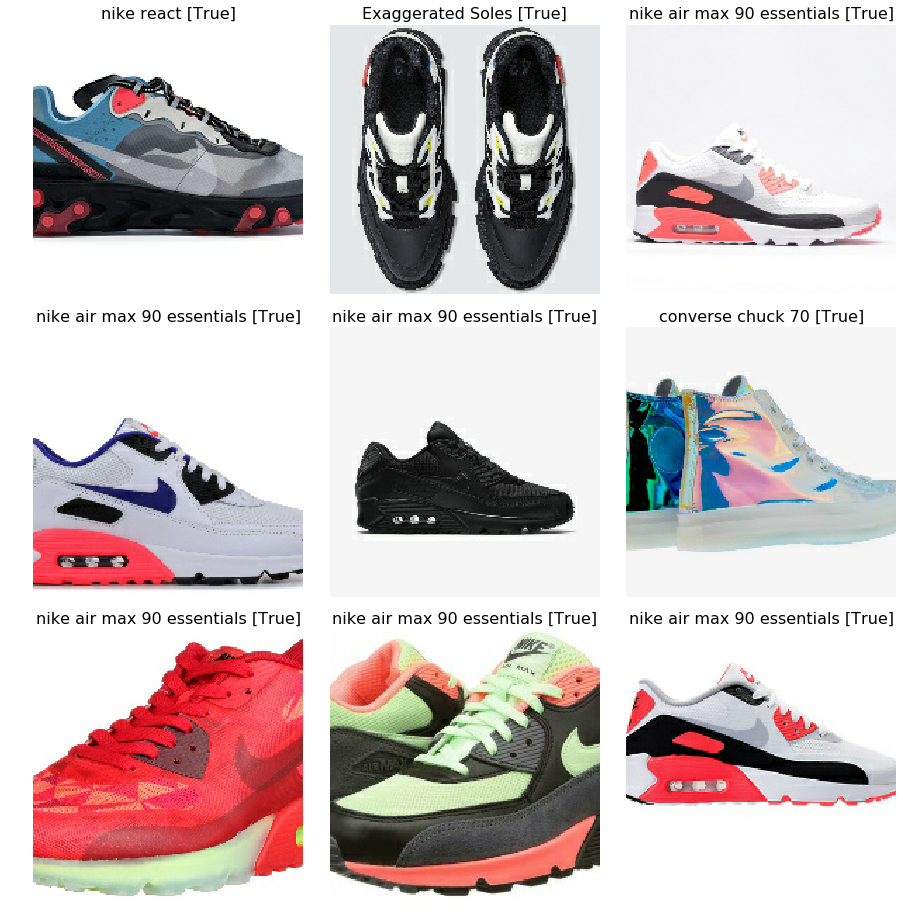

In [133]:
def title_from_label_and_target(predicted_class, target_class):
  """Generate a label based on the match between predicted and target"""
  correct = (predicted_class == target_class)
  
  result = "{} [{}{}{}]".format(CLASSES[predicted_class].decode('utf8'), str(correct), ', shoud be ' if not correct else '',
                              CLASSES[target_class] if not correct else ''), correct
  
  return result


def display_9_images_with_predictions(images, predictions, class_targets):
  """Generate 3x3 grid of predictions with labels / targets"""
  
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  class_targets = class_targets.numpy()

  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], class_targets[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

  

display_9_images_with_predictions(kicks, predictions_raw, class_target)


## Save model

In [0]:
!mkdir models

In [0]:
# Supporting in place is still experimaental
model.save('./models/model_transfered_mobilenet.h5', save_format='h5')

tf.keras.experimental.export_saved_model(model, './models/model_transfered_mobilenet')
# TODO: serving_only=False

W0523 13:59:33.039397 139930961479552 util.py:244] Unresolved object in checkpoint: (root).optimizer
W0523 13:59:33.041135 139930961479552 util.py:244] Unresolved object in checkpoint: (root).optimizer.iter
W0523 13:59:33.042342 139930961479552 util.py:244] Unresolved object in checkpoint: (root).optimizer.beta_1
W0523 13:59:33.050769 139930961479552 util.py:244] Unresolved object in checkpoint: (root).optimizer.beta_2
W0523 13:59:33.052940 139930961479552 util.py:244] Unresolved object in checkpoint: (root).optimizer.decay
W0523 13:59:33.056183 139930961479552 util.py:244] Unresolved object in checkpoint: (root).optimizer.learning_rate
W0523 13:59:33.057748 139930961479552 util.py:244] Unresolved object in checkpoint: (root).layer_with_weights-0.layer_with_weights-1._updates
W0523 13:59:33.061474 139930961479552 util.py:244] Unresolved object in checkpoint: (root).layer_with_weights-0.layer_with_weights-3._updates
W0523 13:59:33.065490 139930961479552 util.py:244] Unresolved object in

In [0]:
!ls -laF models

total 11832
drwxr-xr-x 3 root root     4096 May 23 13:59 ./
drwxr-xr-x 1 root root     4096 May 23 13:50 ../
drwxr-xr-x 4 root root     4096 May 23 13:59 model_transfered_mobilenet/
-rw-r--r-- 1 root root 12096248 May 23 13:59 model_transfered_mobilenet.h5


## Links


*   https://www.tensorflow.org/alpha/tutorials/images/intro_to_cnns
*   https://www.tensorflow.org/alpha/tutorials/images/hub_with_keras
*   https://www.tensorflow.org/alpha/tutorials/images/transfer_learning
*   https://www.tensorflow.org/tensorboard/r2/tensorboard_in_notebooks
*   https://www.tensorflow.org/alpha/tutorials/images/hub_with_keras

